In [1]:
cd ..

/Users/marcolangiu/ownCloud/IEK-10/comando


# A demonstration of the COMANDO framework

Example using components adapted from:
Voll, P., & Bardow, A. (2014). *Automated optimization based synthesis of distributed energy supply systems* (No. RWTH-CONV-143971). Lehrstuhl für Technische Thermodynamik und Institut für Thermodynamik. http://publications.rwth-aachen.de/record/228954}

This example demonstrates the use of COMANDO to
  * model an energy system based on individual components
  * define a simple stochastic optimization problem
  * solve it in the deterministic equivalent form using baron

## First we instantiate some predefined components from our component library

In [2]:
from components.example_components import Grid, Source, Consumer
from examples.IES.IES_components import CombinedHeatAndPower, Boiler, AbsorptionChiller, CompressionChiller

# NOTE: prices and compensation in €/[MWh
# Power:
PG = Grid('Power', price=160, compensation=100,
          feedin_limit=10, constrain_flow=True)

# Heat
GG = Source('Gas ', price=60)
B1 = Boiler('B1')
B2 = Boiler('B2')
CHP = CombinedHeatAndPower('CHP')

# Cooling
AC = AbsorptionChiller('AC')
CC1 = CompressionChiller('CC1')
CC2 = CompressionChiller('CC2')

C = Consumer('Consumer', 'power', 'heat', 'cooling')

## Then we aggregate a system model by specifying:
- which components will be part of the system
- how components will be connected

In [3]:
from comando.core import System

comp = [PG, GG, B1, B2, CHP, AC, CC1, CC2, C]
conn = {
    'Power_Bus': [PG.CONSUMPTION, PG.FEEDIN, CHP.POWER_OUT,
                  CC1.IN, CC2.IN, C.POWER],
    'Gas_Bus': [GG.OUT, B1.IN, B2.IN, CHP.IN],
    'Heat_Bus': [B1.OUT, B2.OUT, CHP.HEAT_OUT, C.HEAT,
                 AC.IN],
    'Cooling_Bus': [AC.OUT, CC1.OUT, CC2.OUT, C.COOLING]}

ES = System('Energy_System', comp, conn)

## Let's see what we got so far

In [4]:
for quantity in ['parameters', 'design_variables', 'operational_variables', 'constraints_dict', 'expressions_dict']:
    print(f'{quantity}\n\t{[*getattr(ES, quantity)]}\n')


parameters
	[Power_price, Power_co2_factor, Power_compensation, Consumer_power_demand, Consumer_heat_demand, Consumer_cooling_demand, Gas _price, Gas _co2_factor]

design_variables
	[CHP__medium_exists, CC1_exists, AC_Qdot_out_nom, B1_Qdot_out_nom, B1_exists, B2_Qdot_out_nom, B2_exists, CHP__small_exists, CHP__small_Qdot_out_nom, CHP__large_exists, CC1_Qdot_out_nom, CHP__medium_Qdot_out_nom, AC_exists, CC2_Qdot_out_nom, CC2_exists, CHP__large_Qdot_out_nom]

operational_variables
	[AC_Qdot_in, CC2_Qdot_out_rel, B1_operating, CHP__small_power_output, CC2_operating, B1_Qdot_out, B2_Qdot_in, CHP__large_Qdot_in, Power_feedin, CC1_Qdot_out_rel, CHP__medium_Qdot_out_rel, CC2_Qdot_out, CC1_operating, CHP__medium_operating, B1_Qdot_in, CHP__small_Qdot_out_rel, Power_consumption, CC1_Qdot_out, CHP__medium_Qdot_out, AC_Qdot_out_rel, CC2_P_in, CHP__large_power_output, CHP__small_operating, AC_operating, B2_Qdot_out_rel, CHP__large_Qdot_out_rel, CHP__small_Qdot_out, CC1_P_in, CHP__medium_Qdot_in, B

## There are symmetries that can complicate solution, let's get rid of them...

In [5]:
# Breaking symmetries
ES.add_le_constraint(B1['Qdot_out_nom'], B2['Qdot_out_nom'],
                     'break_boiler_symmetry')
ES.add_le_constraint(CC1['Qdot_out_nom'], CC2['Qdot_out_nom'],
                     'break_compression_chiller_symmetry')

## Now we can aggregate expressions from components and construct an objective function
Here we want to consider **total annualized cost**, consisting of
- annualized investment costs and fixed annual costs (e.g. maintenance)
- the integral over variable costs for operation

since this is a typical objective, we created a helper function for this in `comando.utility` (also check out the other useful helper functions in there)!

In [6]:
from comando.utility import make_tac_objective

# n is the assumed accounting period and i the interest rate
d_obj, o_obj = make_tac_objective(ES, n=10, i=0.08)

## Let's check what these expressions look like:

In [7]:
d_obj

28.3007688323411*AC_Qdot_out_nom**0.4345 + 9.93443056685799*B1_Qdot_out_nom**0.4502 + 9.93443056685799*B2_Qdot_out_nom**0.4502 + 32.644188190893*CC1_Qdot_out_nom**0.8632 + 32.644188190893*CC2_Qdot_out_nom**0.8632 + 96.2173583223671*CHP__large_Qdot_out_nom**0.539 + 96.2173583223671*CHP__medium_Qdot_out_nom**0.539 + 96.2173583223671*CHP__small_Qdot_out_nom**0.539

In [8]:
o_obj

Gas _price*Gas _use - Power_compensation*Power_feedin + Power_price*Power_consumption

## We can define a (simple) problem based on
- our system model
- the defined objectives
- a considered operating horizon $\mathcal{T} = 8760\,\text{h}$, split into four seasons of equal length
- three scenarios with different probabilities

In [9]:
ts = ['winter', 'spring', 'summer', 'autumn']
scenarios = {'best': .1, 'likely': .7, 'worst': .2}

# Operational parameter data is in XXX / h
# if we consider 8760 timesteps we got one year
# We scale the objective to million € / year
P = ES.create_problem(d_obj * 1e-6, o_obj * 1e-6, (ts, 8760), scenarios,
                      name='Test_Problem')
print(f'{P.name} has {P.num_vars} variables, {P.num_cons} constraints and the objective is:')
P.objective

Test_Problem has 472 variables, 790 constraints and the objective is:


0.000219*Gas _price*Gas _use[('best', 'autumn')] + 0.000219*Gas _price*Gas _use[('best', 'spring')] + 0.000219*Gas _price*Gas _use[('best', 'summer')] + 0.000219*Gas _price*Gas _use[('best', 'winter')] + 0.001533*Gas _price*Gas _use[('likely', 'autumn')] + 0.001533*Gas _price*Gas _use[('likely', 'spring')] + 0.001533*Gas _price*Gas _use[('likely', 'summer')] + 0.001533*Gas _price*Gas _use[('likely', 'winter')] + 0.000438*Gas _price*Gas _use[('worst', 'autumn')] + 0.000438*Gas _price*Gas _use[('worst', 'spring')] + 0.000438*Gas _price*Gas _use[('worst', 'summer')] + 0.000438*Gas _price*Gas _use[('worst', 'winter')] - 0.000219*Power_compensation*Power_feedin[('best', 'autumn')] - 0.000219*Power_compensation*Power_feedin[('best', 'spring')] - 0.000219*Power_compensation*Power_feedin[('best', 'summer')] - 0.000219*Power_compensation*Power_feedin[('best', 'winter')] - 0.001533*Power_compensation*Power_feedin[('likely', 'autumn')] - 0.001533*Power_compensation*Power_feedin[('likely', 'spring

## Let's look at the data we need to specify for this problem

In [10]:
P.data

## We can specify values for parameters that depend only on time or scenario via data of appropriate length:


In [11]:
# constant (for simplicity)
P['Consumer_power_demand'] = 1  # MW

# time-dependent; the same for all scenarios
P['Consumer_cooling_demand'] = 1.2, 1.3, 2.6, 1.9  # MW
P['Consumer_heat_demand'] = 2.4, 1.5, .7, 1.5  # MW

# scenario dependent; the same for all time-steps
P['Power_compensation'] = 160, 100, 0
P.data

## We can adapt data for individual scenarios or time-steps:


In [12]:
P.data['Consumer_cooling_demand']['best'] *= 0.9
P.data['Consumer_cooling_demand']['worst'] *= 1.2  # peak cooling demand

# We can also access and modify parameter values over the parameter objects' `value` attribute
P['Consumer_heat_demand'].value['worst'] *= 1.8  # peak heating demand
P.data

## And here are the current (default) values for the decision variables:

In [13]:
P.design

,value
name,
AC_Qdot_out_nom,2
AC_exists,1
B1_Qdot_out_nom,14
B1_exists,1
B2_Qdot_out_nom,14
B2_exists,1
CC1_Qdot_out_nom,10
CC1_exists,1
CC2_Qdot_out_nom,10


In [14]:
P.operation

s                          best                      likely                \
t                        winter spring summer autumn winter spring summer   
name                                                                        
AC_Qdot_in                2.985  2.985  2.985  2.985  2.985  2.985  2.985   
AC_Qdot_out                   2      2      2      2      2      2      2   
AC_Qdot_out_rel               1      1      1      1      1      1      1   
AC_operating                  1      1      1      1      1      1      1   
B1_Qdot_in                15.52  15.52  15.52  15.52  15.52  15.52  15.52   
B1_Qdot_out                  14     14     14     14     14     14     14   
B1_Qdot_out_rel               1      1      1      1      1      1      1   
B1_operating                  1      1      1      1      1      1      1   
B2_Qdot_in                15.52  15.52  15.52  15.52  15.52  15.52  15.52   
B2_Qdot_out                  14     14     14     14     14     14     14   
B2_Qdot_out_rel               1      1      1      1      1      1      1   
B2_operating                  1      1      1      1      1      1      1   
CC1_P_in                  1.798  1.798  1.798  1.798  1.798  1.798  1.798   
CC1_Qdot_out                 10     10     10     10     10     10     10   
CC1_Qdot_out_rel              1      1      1      1      1      1      1   
CC1_operating                 1      1      1      1      1      1      1   
CC2_P_in                  1.798  1.798  1.798  1.798  1.798  1.798  1.798   
CC2_Qdot_out                 10     10     10     10     10     10     10   
CC2_Qdot_out_rel              1      1      1      1      1      1      1   
CC2_operating                 1      1      1      1      1      1      1   
CHP__large_Qdot_in          3.2    3.2    3.2    3.2    3.2    3.2    3.2   
CHP__large_Qdot_out         3.2    3.2    3.2    3.2    3.2    3.2    3.2   
CHP__large_Qdot_out_rel       1      1      1      1      1      1      1   
CHP__large_operating          1      1      1      1      1      1      1   
CHP__large_power_output   1.877  1.877  1.877  1.877  1.877  1.877  1.877   
CHP__medium_Qdot_in         2.3    2.3    2.3    2.3    2.3    2.3    2.3   
CHP__medium_Qdot_out        2.3    2.3    2.3    2.3    2.3    2.3    2.3   
CHP__medium_Qdot_out_rel      1      1      1      1      1      1      1   
CHP__medium_operating         1      1      1      1      1      1      1   
CHP__medium_power_output  1.164  1.164  1.164  1.164  1.164  1.164  1.164   
CHP__small_Qdot_in          1.4    1.4    1.4    1.4    1.4    1.4    1.4   
CHP__small_Qdot_out         1.4    1.4    1.4    1.4    1.4    1.4    1.4   
CHP__small_Qdot_out_rel       1      1      1      1      1      1      1   
CHP__small_operating          1      1      1      1      1      1      1   
CHP__small_power_output   0.592  0.592  0.592  0.592  0.592  0.592  0.592   
Gas _use                      0      0      0      0      0      0      0   
Power_consumption             0      0      0      0      0      0      0   
Power_feedin                  5      5      5      5      5      5      5   

s                                worst                       
t                        autumn winter spring summer autumn  
name                                                         
AC_Qdot_in                2.985  2.985  2.985  2.985  2.985  
AC_Qdot_out                   2      2      2      2      2  
AC_Qdot_out_rel               1      1      1      1      1  
AC_operating                  1      1      1      1      1  
B1_Qdot_in                15.52  15.52  15.52  15.52  15.52  
B1_Qdot_out                  14     14     14     14     14  
B1_Qdot_out_rel               1      1      1      1      1  
B1_operating                  1      1      1      1      1  
B2_Qdot_in                15.52  15.52  15.52  15.52  15.52  
B2_Qdot_out                  14     14     14     14     14  
B2_Qdot_out_rel               1     

## This combination of design and operating decisions is not feasible:

In [15]:
P.get_constraint_violations(larger_than=1e-5)

CHP__large_input_output_power[('best', 'autumn')]     0.3739
CHP__large_input_output_power[('best', 'spring')]     0.3739
CHP__large_input_output_power[('best', 'summer')]     0.3739
CHP__large_input_output_power[('best', 'winter')]     0.3739
CHP__large_input_output_power[('likely', 'autumn')]   0.3739
                                                       ...  
Energy_System_Power_Bus[('likely', 'winter')]          5.964
Energy_System_Power_Bus[('worst', 'autumn')]           5.964
Energy_System_Power_Bus[('worst', 'spring')]           5.964
Energy_System_Power_Bus[('worst', 'summer')]           5.964
Energy_System_Power_Bus[('worst', 'winter')]           5.964
Name: violation, Length: 121, dtype: float64

## To get a feasible (and ideally optimal) system design we can solve an optimization problem.
Let's look at some of the expressions in our model...

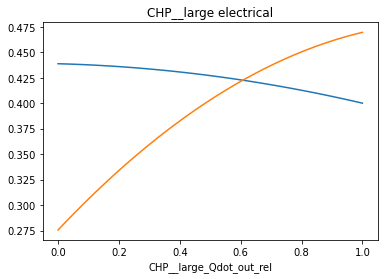

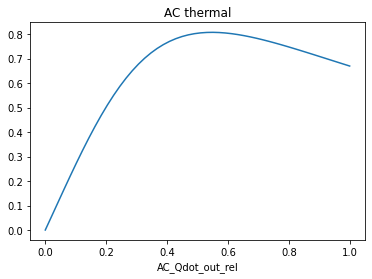

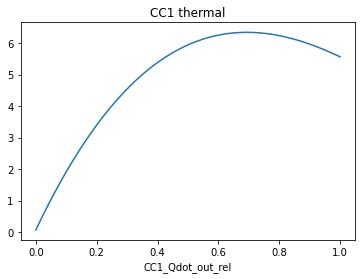

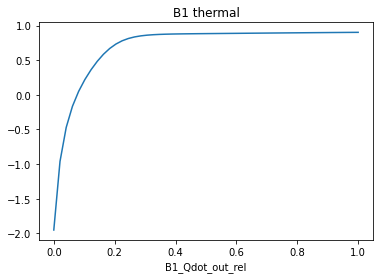

In [16]:
from comando.visualization import plot_expr, plt

for c in [CHP, AC, CC1, B1]:
    if c.label == 'CHP':
        # NOTE: CHP consists of 3 submodels (small, medium, and large), we look at one
        for c in CHP.components:
            plot_expr(c.get_expression('eff_th'), label=c.label + " thermal")
            plot_expr(c.get_expression('eff_el'), label=c.label + " electrical")
            break
    else:
        plt.figure()
        plot_expr(c.get_expression('eff'), label=c.label + " thermal")
            

## Since some of the expressions in our model are nonlinear and we have integer decisions (build / don't build, on / off) in our model, the problem has a MINLP formulation and we will need to use solver like BARON that can handle such formulations.

In [17]:
from comando.interfaces.baron import solve
import tempfile

with tempfile.TemporaryDirectory() as tmpdir:
     print('created temporary directory', tmpdir)

     # Create baron input file in tempdir, solve problem and read back solution
     solve(P, f'{tmpdir}/Test_Problem.bar', MaxTime=120)

searching for libcplex12100.dylib...
...found at /Applications/CPLEX_Studio1210/cplex/bin/x86-64_osx/libcplex12100.dylib!
Temporarily adding to DYLD_LIBRARY_PATH!
created temporary directory /var/folders/jh/7pbppps546b01mlnk0z56p700000gn/T/tmpq8_alwle
INFO: Constraint "Consumer_POWER" contains only parameters and evaluates to True! Skipping...
INFO: Constraint "Consumer_HEAT" contains only parameters and evaluates to True! Skipping...
INFO: Constraint "Consumer_COOLING" contains only parameters and evaluates to True! Skipping...
 BARON version 21.1.13. Built: OSX-64 Wed Jan 13 16:19:52 EST 2021

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Manuel Dahmen at Forschungszentrum Juelich GmbH, m.dahmen@fz-juelich.de.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Kilinc, M. and N. V. Sahinidis, Exploiting integrality in the global
 optimization of mixed-integ

## BARON manages to find a feasible solution (with respect to tolerances), but within the time-limit of 60 s the optimality gap cannot be closed.

Maximum constraint violation: 5.385414336700478e-12


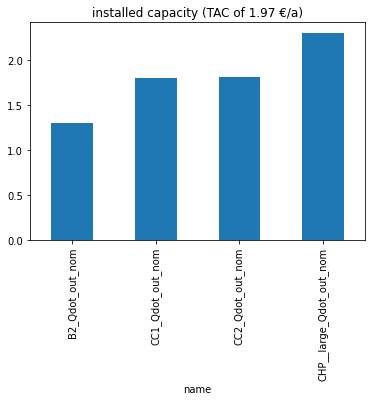

In [18]:
print('Maximum constraint violation:', P.get_constraint_violations().max())
P.design['value'][P.design['value']>1].plot(kind='bar', title=f'installed capacity (TAC of {P.objective.value:.2f} €/a)');

In [19]:
print("Resulting design")
P.design

Resulting design


,value
name,
AC_Qdot_out_nom,0.6069
AC_exists,1
B1_Qdot_out_nom,0.1001
B1_exists,1
B2_Qdot_out_nom,1.298
B2_exists,1
CC1_Qdot_out_nom,1.796
CC1_exists,1
CC2_Qdot_out_nom,1.803


In [20]:
print("Resulting operation")
P.operation

Resulting operation


s                           best                          likely          \
t                         winter  spring  summer  autumn  winter  spring   
name                                                                       
AC_Qdot_in                0.2533  0.2709  0.8779  0.3283  0.2431  0.2446   
AC_Qdot_out               0.1489  0.1807   0.595  0.2553  0.1256  0.1291   
AC_Qdot_out_rel           0.2453  0.2977  0.9804  0.4207  0.2069  0.2128   
AC_operating                   1       1       1       1       1       1   
B1_Qdot_in               0.07956 0.05496 0.03166 0.06104 0.07279 0.03645   
B1_Qdot_out              0.07095 0.04853 0.02642 0.05403 0.06474  0.0315   
B1_Qdot_out_rel           0.7088  0.4848  0.2639  0.5397  0.6468  0.3147   
B1_operating                   1       1       1       1       1       1   
B2_Qdot_in                 1.371  0.4411   0.362  0.4922   1.362  0.4272   
B2_Qdot_out                1.234  0.3765  0.2666  0.4274   1.226  0.3616   
B2_Qdot_out_rel           0.9512  0.2901  0.2055  0.3294  0.9447  0.2787   
B2_operating                   1       1       1       1       1       1   
CC1_P_in                   0.169   0.178  0.1628  0.2783   0.172  0.1852   
CC1_Qdot_out               1.051   1.119   1.001   1.645   1.074   1.171   
CC1_Qdot_out_rel          0.5854  0.6234  0.5572   0.916  0.5984  0.6521   
CC1_operating                  1       1       1       1       1       1   
CC2_P_in                       0       0  0.1634       0       0       0   
CC2_Qdot_out                   0       0   1.005       0       0       0   
CC2_Qdot_out_rel               0       0  0.5572       0       0       0   
CC2_operating                  0       0       1       0       0       0   
CHP__large_Qdot_in         3.182   3.177   3.025   3.179   3.194   3.191   
CHP__large_Qdot_out        1.348   1.346   1.285   1.347   1.352   1.351   
CHP__large_Qdot_out_rel   0.5859   0.585  0.5584  0.5854  0.5878  0.5874   
CHP__large_operating           1       1       1       1       1       1   
CHP__large_power_output    1.333   1.331   1.253   1.332   1.339   1.338   
CHP__medium_Qdot_in            0       0       0       0       0       0   
CHP__medium_Qdot_out           0       0       0       0       0       0   
CHP__medium_Qdot_out_rel       0       0       0       0       0       0   
CHP__medium_operating          0       0       0       0       0       0   
CHP__medium_power_output       0       0       0       0       0       0   
CHP__small_Qdot_in             0       0       0       0       0       0   
CHP__small_Qdot_out            0       0       0       0       0       0   
CHP__small_Qdot_out_rel        0       0       0       0       0       0   
CHP__small_operating           0       0       0       0       0       0   
CHP__small_power_output        0       0       0       0       0       0   
Gas _use                   4.633   3.673   3.418   3.733   4.628   3.655   
Power_consumption              0       0 0.07339       0       0       0   
Power_feedin              0.1644  0.1527       0  0.0536  0.1673  0.1527   

s                                           worst                           
t                           summer  autumn winter  spring  summer   autumn  
name                                                                        
AC_Qdot_in                  0.9025  0.2669 0.2423  0.2453  0.8942   0.2468  
AC_Qdot_out                 0.6055  0.1741 0.1235   0.131   0.602   0.1346  
AC_Qdot_out_rel             0.9977   0.287 0.2035  0.2159  0.9919   0.2217  
AC_operating                     1       1      1       1       1        1  
B1_Qdot_in                       0  0.0387      0 0.05603 0.02916  0.04893  
B1_Qdot_out                      0 0.03368      0 0.04949 0.02306  0.04308  
B1_Qdot_out_rel                  0  0.3364      0  0.4945  0.2303   0.4304  
B1_operating                     0       1      0       1       1        1  
B2_Qdot_in                    0.36  

## And here we have the operational schedule for different scenarios and time steps

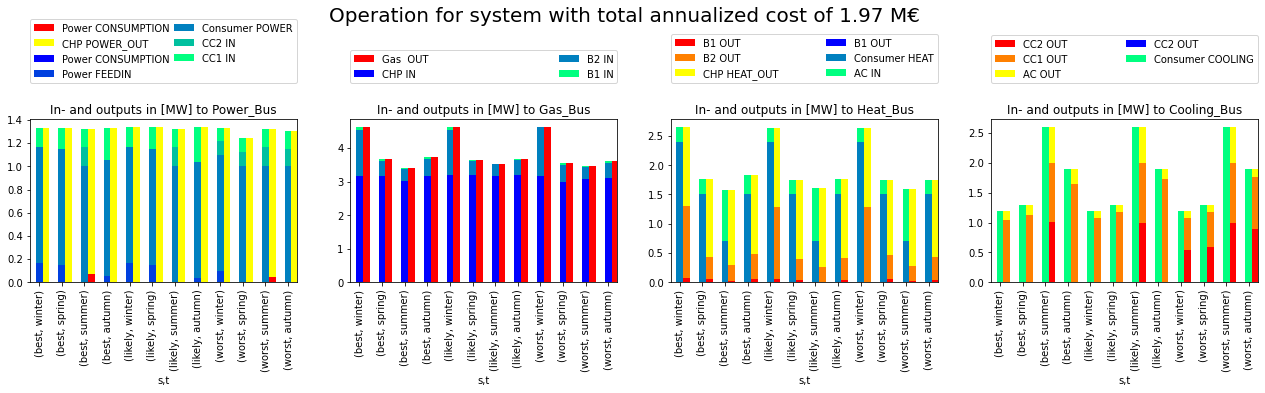

In [21]:
from pandas import DataFrame
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(22, 3))
title = 'Operation for system with total annualized cost of ' \
        f'{P.objective.value:.2f} M€'
fig.suptitle(title, fontsize=20, y=1.4)
# Inputs to bus (coming from components)
# Outputs from bus (going into components)
for ax, bus in zip(axs, ES.connections):
    data = DataFrame({f'{c.component.label} {c.name}': c.expr.value
                      for c in ES.connections[bus]})
    ax.set_title(f'In- and outputs in [MW] to {bus}')
    opts = dict(kind='bar', stacked=True, width=0.3, ax=ax)
    (-data[data<0]).dropna(1, 'all').plot(position=-0.5, colormap='autumn', **opts);
    data[data>=0].dropna(1, 'all').plot(position=+0.5, colormap='winter', **opts) \
        .legend(bbox_to_anchor=(0., 1.22, 1., .102), loc='lower left',
                ncol=2, mode="expand", borderaxespad=0.);